In [17]:
import scipy
import statsmodels
import sklearn
import theano
import tensorflow
import keras

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
#read history data used to train model
dataset = pd.read_csv('./Data/BYD751_2021-01-06-0000_2021-01-16-0000.csv', index_col=False)
dataset.columns

Index(['Unix Timestamp [ms]', 'Time ISO', 'Time [US/Eastern]', 'Name',
       'Analysis - other - Acceleration [ft/s?]',
       'Analysis - other - Distance driven [mi]',
       'Analysis - other - Power [kW]', 'Dashboard - Speed [mi/h]',
       'Engine - RPM [RPM]', 'GPS - Altitude [m]',
       'GPS - GPS position Latitude', 'GPS - GPS position Longitude'],
      dtype='object')

In [3]:
#process raw data
dataset = dataset.interpolate()
dataset['elevation']=0 #fix here
dataset['elevdiff']=dataset['elevation'].diff() #ft
dataset['elevdiff']=dataset['elevation']*0.000189394 #convert ft to mile
dataset['distdiff']=dataset['Analysis - other - Distance driven [mi]'].diff()
dataset['roadGrade']=dataset['elevdiff']/dataset['distdiff']
dataset['temperature']=0 #fix here
dataset['humidity']=0 #fix here
dataset['Speed']=dataset['Dashboard - Speed [mi/h]'] 
dataset['Speed2'] = dataset['Speed'].pow(2)
dataset['Speed3'] = dataset['Speed'].pow(3)
dataset['Acc'] = dataset['Analysis - other - Acceleration [ft/s?]']
dataset['AccSpeed'] = dataset['Acc'] * dataset['Speed']
dataset['Pow'] = dataset['Analysis - other - Power [kW]']
dataset['PowIndex'] = 1
neg_pow = dataset['Pow'] < 0
dataset.loc[neg_pow,'PowIndex'] = 0
dataset=dataset.dropna()

In [4]:
#Split train and test data and partition data by vehicle status
train = dataset.sample(n=math.floor(0.8*dataset.shape[0]))
test = dataset.sample(n=math.ceil(0.2*dataset.shape[0]))

train_accInd = train['Acc'] > 2
train_decInd = train['Acc'] < -2
train_crzInd = (train['Acc'] <= 2) & (train['Acc'] >= -2)
train_acc = train[train_accInd]
train_dec = train[train_decInd]
train_crz = train[train_crzInd]
print("# of acceleration samples for training: ", train_acc.shape[0])
print("# of decelearation samples for training: ", train_dec.shape[0])
print("# of cruizing samples for training: ", train_crz.shape[0])

test_accInd = test['Acc'] > 2
test_decInd = test['Acc'] < -2
test_crzInd = (test['Acc'] <= 2) & (test['Acc'] >= -2)
test_acc = test[test_accInd]
test_dec = test[test_decInd]
test_crz = test[test_crzInd]
print("# of acceleration samples for testing: ", test_acc.shape[0])
print("# of decelearation samples for testing: ", test_dec.shape[0])
print("# of cruizing samples for testing: ", test_crz.shape[0])

# of acceleration samples for training:  8051
# of decelearation samples for training:  7520
# of cruizing samples for training:  56531
# of acceleration samples for testing:  1983
# of decelearation samples for testing:  1862
# of cruizing samples for testing:  14181


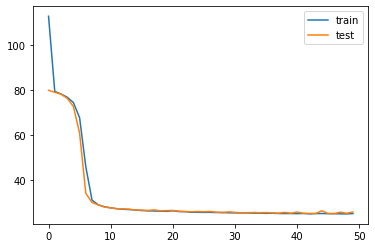

In [12]:
#Construct and compile models, using Mean Absolute Error for regression prediction models, Cross-entropy for power sign prediction model
#Fit each model seperately    
### Model for accelerating status
Y_train_acc = train_acc['Pow']
X_train_acc = train_acc[['Acc','Speed','Speed2','Speed3','AccSpeed']]

Y_test_acc = test_acc['Pow']
X_test_acc = test_acc[['Acc','Speed','Speed2','Speed3','AccSpeed']]

model_acc = Sequential()
model_acc.add(Dense(10,kernel_initializer='normal', input_dim=5, activation ='relu'))
model_acc.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_acc.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_acc.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_acc.compile(loss='mean_absolute_error', optimizer='adam')

history = model_acc.fit(X_train_acc, Y_train_acc, validation_data=(X_test_acc, Y_test_acc), epochs=50, batch_size=100, verbose = 0)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


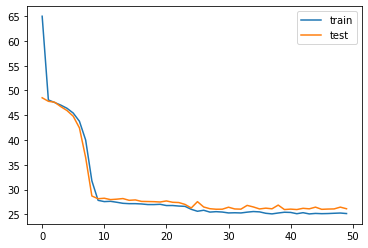

In [6]:
### Model for decelerating status
Y_train_dec = train_dec['Pow']
X_train_dec = train_dec[['Acc','Speed','Speed2','Speed3','AccSpeed']]

Y_test_dec = test_dec['Pow']
X_test_dec = test_dec[['Acc','Speed','Speed2','Speed3','AccSpeed']]

model_dec = Sequential()
model_dec.add(Dense(10,kernel_initializer='normal', input_dim=5, activation ='relu'))
model_dec.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_dec.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_dec.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_dec.compile(loss='mean_absolute_error', optimizer='adam')

history = model_dec.fit(X_train_dec, Y_train_dec, validation_data=(X_test_dec, Y_test_dec), epochs=50, batch_size=100, verbose = 0)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

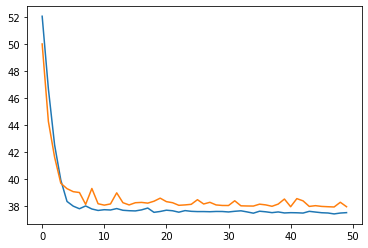

In [7]:
### Cruizing model
Y_train_crz = train_crz['Pow']
X_train_crz = train_crz[['Acc','Speed','Speed2','Speed3','AccSpeed']]

Y_test_crz = test_crz['Pow']
X_test_crz = test_crz[['Acc','Speed','Speed2','Speed3','AccSpeed']]

model_crz = Sequential()
model_crz.add(Dense(10,kernel_initializer='normal', input_dim=5, activation ='relu'))
model_crz.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_crz.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_crz.add(Dense(1,kernel_initializer='normal', activation ='linear'))

model_crz.compile(loss='mean_absolute_error', optimizer='adam')

history = model_crz.fit(X_train_crz, Y_train_crz, validation_data=(X_test_crz, Y_test_crz), epochs=50, batch_size=256, verbose = 0)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show()

In [13]:
#read trajectory data that needs prediction
trip = pd.read_csv("./Route1_trip151720020_061000.csv")
trip1=trip[['speed','acceleration']]
input4pre=pd.DataFrame()  
input4pre['Acc']=trip1['acceleration']*(0.001)*3.28
#ft/s2
input4pre['Speed']=trip1['speed']*(0.01*3.6) *0.621371
#mph
input4pre['Speed2'] = input4pre['Speed'].pow(2)
input4pre['Speed3'] = input4pre['Speed'].pow(3)
input4pre['AccSpeed'] = input4pre['Acc'] * input4pre['Speed']
input4pre=input4pre[['Acc','Speed','Speed2','Speed3','AccSpeed']]
print(input4pre.columns)

Index(['Acc', 'Speed', 'Speed2', 'Speed3', 'AccSpeed'], dtype='object')


In [14]:
#partition data
pre_accIdx = input4pre['Acc'] > 2
pre_decIdx = input4pre['Acc'] < -2
pre_crzIdx = (input4pre['Acc'] <= 2) & (input4pre['Acc'] >= -2)
pre_acc = input4pre[pre_accIdx]
pre_dec = input4pre[pre_decIdx]
pre_crz = input4pre[pre_crzIdx]

In [15]:
#prediction
pow_acc = model_acc.predict(pre_acc)
pow_dec = model_dec.predict(pre_dec)
pow_crz = model_crz.predict(pre_crz)
trip_acc = trip[pre_accIdx]
trip_dec = trip[pre_decIdx]
trip_crz = trip[pre_crzIdx]
trip_acc = trip_acc.reset_index(drop=True)
trip_dec = trip_dec.reset_index(drop=True)
trip_crz = trip_crz.reset_index(drop=True)
trip_accP = pd.concat([trip_acc,pd.DataFrame(pow_acc,columns=['Power'])], axis=1)
trip_decP = pd.concat([trip_dec,pd.DataFrame(pow_dec,columns=['Power'])], axis=1)
trip_crzP = pd.concat([trip_crz,pd.DataFrame(pow_crz,columns=['Power'])], axis=1)
tripfinal = pd.concat([trip_accP,trip_decP,trip_crzP])
tripfinal.Power[tripfinal.Power < -200] = -200
tripfinal = tripfinal.sort_values(by=['time_ms'])
tripfinal = tripfinal.reset_index(drop=True)
print(tripfinal.head())

       time   time_ms  speed  acceleration                    vehicle_ref  \
0  06:10:00  22200000      0             0  Route1_trip151720020_06:10:00   
1  06:10:01  22201000      0             0  Route1_trip151720020_06:10:00   
2  06:10:02  22202000      0             0  Route1_trip151720020_06:10:00   
3  06:10:03  22203000      0             0  Route1_trip151720020_06:10:00   
4  06:10:04  22204000      0             0  Route1_trip151720020_06:10:00   

   actorConfig_id actorConfig_emissionClass actorConfig_fuel actorConfig_ref  \
0               7                     Euro4         Gasoline      Gillig_101   
1               7                     Euro4         Gasoline      Gillig_101   
2               7                     Euro4         Gasoline      Gillig_101   
3               7                     Euro4         Gasoline      Gillig_101   
4               7                     Euro4         Gasoline      Gillig_101   

  actorConfig_vehicleClass     Power  
0                

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


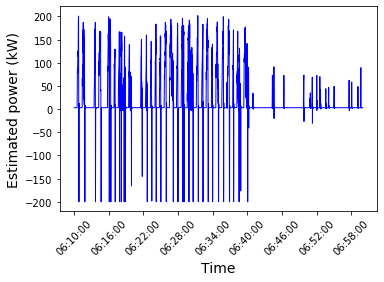

In [16]:
#plot results
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(tripfinal.index, tripfinal.Power, color='blue', linewidth=1)
ax1.set_xticks(tripfinal.index[::360])
ax1.set_xticklabels(tripfinal.time[::360], rotation=45)
plt.tight_layout(pad=4)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("Time",fontsize = 14)
plt.ylabel("Estimated power (kW)",fontsize = 14)
plt.show()